In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")  # To keep the output clean


In [3]:
df = pd.read_csv('../../../data/df_final.csv',index_col='date', parse_dates=True)


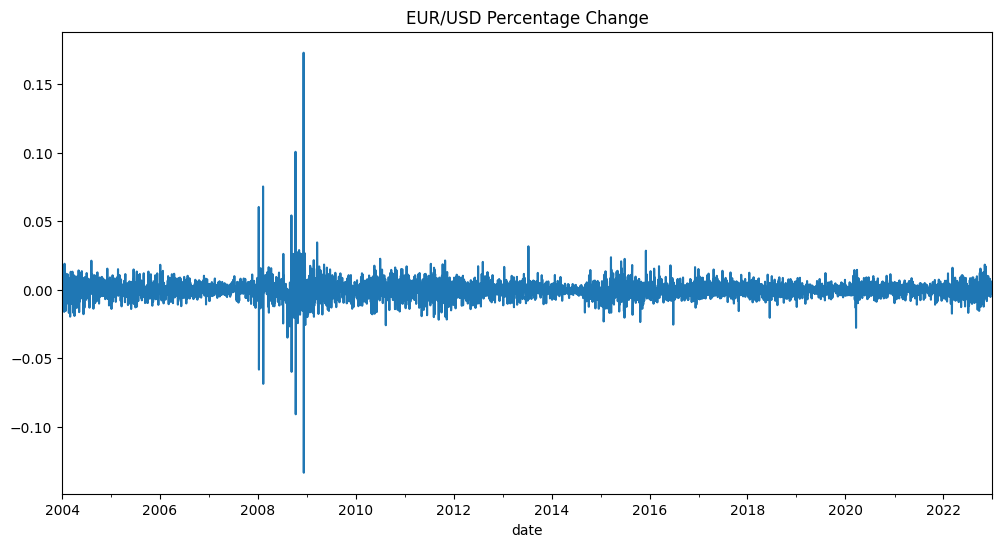

In [4]:
# Plot the data
df['eurusd_pct_change'].plot(title='EUR/USD Percentage Change', figsize=(12, 6))
plt.show()

In [5]:
def ts_train_test_normalize(df, time_steps, for_periods, target_column=1):
    # Identifying indices for splitting
    times = sorted(df.index.values)
    last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # Last 10% of series
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # Last 20% of series

    # Splitting the data
    ts_train = df[(df.index < last_20pct)]
    ts_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
    ts_test = df[(df.index >= last_10pct)]

    # Scaling the data
    sc = StandardScaler().fit(ts_train)
    ts_train_scaled = sc.transform(ts_train)
    ts_val_scaled = sc.transform(ts_val)
    ts_test_scaled = sc.transform(ts_test)

    # Preparing the output arrays
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    for i in range(time_steps, len(ts_train_scaled)-for_periods):
        X_train.append(ts_train_scaled[i-time_steps:i])
        y_train.append(ts_train_scaled[i:i+for_periods, target_column])
    for i in range(time_steps, len(ts_val_scaled)-for_periods):
        X_val.append(ts_val_scaled[i-time_steps:i])
        y_val.append(ts_val_scaled[i:i+for_periods, target_column])
    for i in range(time_steps, len(ts_test_scaled)-for_periods):
        X_test.append(ts_test_scaled[i-time_steps:i])
        y_test.append(ts_test_scaled[i:i+for_periods, target_column])

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), sc


In [6]:
# Specify the target column
target_column = list(df.columns).index('eurusd_pct_change')

# Normalize and split the data
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_train_test_normalize(df, 1, 1, target_column)

In [7]:
# Using the ADF test on the training set to check for stationarity
result = adfuller(X_train[:, 0, target_column])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -11.750486987611684
p-value: 1.2124957613712002e-21


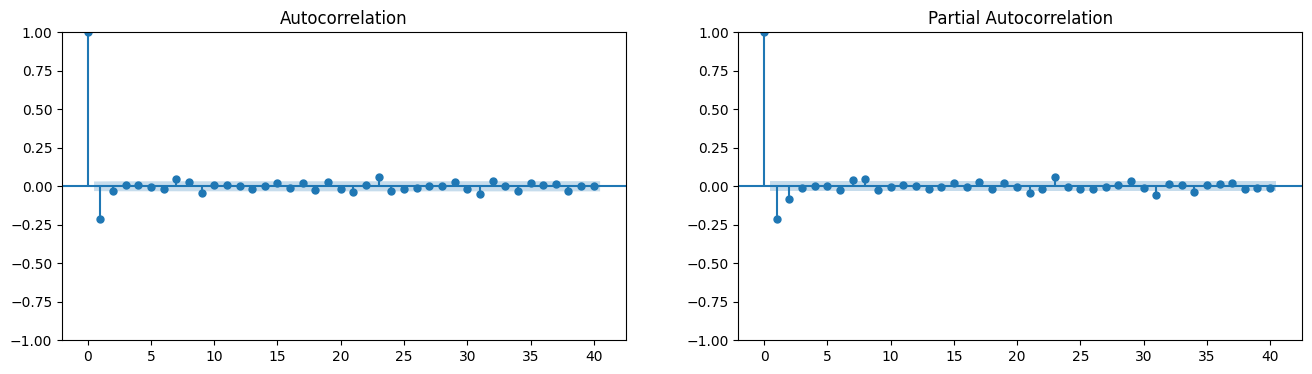

In [8]:
# Check for need to difference
if result[1] > 0.05:  # non-stationary
    d = 1
else:
    d = 0

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(X_train[:, 0, target_column], lags=40, ax=axes[0])
plot_pacf(X_train[:, 0, target_column], lags=40, ax=axes[1], method='ywm')
plt.show()


In [9]:
# Fit ARIMA based on determined orders p, d, q
p = 1  # from PACF
q = 2  # from ACF
model = ARIMA(X_train[:, 0, target_column], order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3964
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -5521.792
Date:                Sun, 30 Jun 2024   AIC                          11053.585
Time:                        17:45:40   BIC                          11085.010
Sample:                             0   HQIC                         11064.729
                               - 3964                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.013     -0.020      0.984      -0.026       0.026
ar.L1         -0.3653      0.321     -1.138      0.255      -0.994       0.264
ma.L1          0.1361      0.321      0.424      0.6

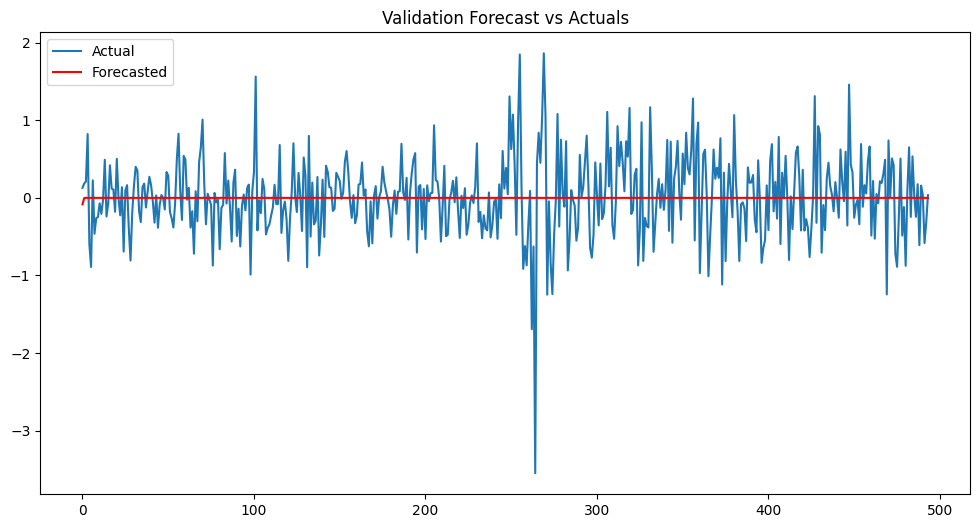

In [10]:
# Forecasting
preds = fitted_model.forecast(steps=len(X_val))
plt.figure(figsize=(12, 6))
plt.plot(y_val[:, 0], label='Actual')
plt.plot(preds, label='Forecasted', color='red')
plt.title('Validation Forecast vs Actuals')
plt.legend()
plt.show()
